<a href="https://colab.research.google.com/github/PomipatK/Car_Price_Prediction/blob/main/Car_Price_Prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d deepcontractor/car-price-prediction-challenge

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge
License(s): CC0-1.0
car-price-prediction-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/car_price_prediction.csv')

# Data Validation


This dataset has 19237 rows, 18 columns. The data was not clean. I have validated data by eliminating duplicating rows, handling with missing values, and correcting data format. After validation, I have made changes to some features.
*   ID: Numeric, no need cleaning.
*   Price: Numeric, remove outliers.
*   Levy: Numeric, impute null values with median.
*   Manufacturer: Category, no need cleaning.
*   Model: Category, no need cleaning.
*   Prod. year: Numeric, no need cleaning.
*   Category: Category, no need cleaning.
*   Leather interior: Binary, convert to binary value which refers 1 to 'yes' and 0 to 'False'.
*   Fuel type: Category, no need cleaning.
*   Engine volume	: Numeric, split column contains 'Turbo' to new feature `engine_turbo`.
*   Mileage: Numeric, remove 'km' in the last.
*   Cylinders: Numneric, no need cleaning.
*   Gear box type: Category, no need cleaning.
*   Drive wheels: Category, no need cleaning.
*   Doors: Feature was **deleted** because there are some ambiguous values.
*   Wheel: Change name to `R_Wheel` that refers 1 to 'Right-wheel' and 0 to 'Left-wheel'
*   Color: Category, no need cleaning.
*   Airbags: Numneric, no need cleaning.










In [ ]:
df.head(5)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [ ]:
df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


## Duplicated values

In [ ]:
df[df.ID.duplicated(keep=False)].sort_values('ID').head(8) # ดูข้อมูลที่เลข ID เหมือนกัน
## พบว่า ข้อมูลที่ ID เดียวกันเป็นข้อมูลที่เหมือนกัน

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
5754,35464629,7840,1111,HONDA,FIT,2012,Hatchback,No,Petrol,1.3,108000 km,4.0,Automatic,Front,04-May,Right-hand drive,Blue,6
7269,35464629,7840,1111,HONDA,FIT,2012,Hatchback,No,Petrol,1.3,108000 km,4.0,Automatic,Front,04-May,Right-hand drive,Blue,6
1107,36559154,19726,-,MERCEDES-BENZ,Sprinter 411,2002,Goods wagon,No,Diesel,2.2 Turbo,280000 km,4.0,Manual,Rear,02-Mar,Left wheel,White,2
6732,36559154,19726,-,MERCEDES-BENZ,Sprinter 411,2002,Goods wagon,No,Diesel,2.2 Turbo,280000 km,4.0,Manual,Rear,02-Mar,Left wheel,White,2
9990,41770767,11917,-,NISSAN,Murano,2004,Jeep,Yes,CNG,3.5,233600 km,6.0,Variator,4x4,04-May,Left wheel,Silver,6
13822,41770767,11917,-,NISSAN,Murano,2004,Jeep,Yes,CNG,3.5,233600 km,6.0,Variator,4x4,04-May,Left wheel,Silver,6
8158,42412373,15367,781,CHEVROLET,Trax,2018,Jeep,Yes,Petrol,1.4,1405 km,4.0,Automatic,4x4,04-May,Left wheel,Black,8
9275,42412373,15367,781,CHEVROLET,Trax,2018,Jeep,Yes,Petrol,1.4,1405 km,4.0,Automatic,4x4,04-May,Left wheel,Black,8


In [ ]:
df.ID.duplicated().sum()

313

In [ ]:
# Drop duplicated values
df.drop_duplicates(inplace=True)
df.ID.duplicated().sum()

0

## Exploring for each features

In [ ]:
df['Mileage'] = df['Mileage'].apply(lambda x : int(x.replace("km","")))
print(df['Mileage'].head())

0    186005
1    192000
2    200000
3    168966
4     91901
Name: Mileage, dtype: int64


In [ ]:
df['engine_turbo'] = np.where(df['Engine volume'].str.contains('Turbo'), 1, 0) # เพิ่ม engine_turbo column จาก Engine volume column
print(df['engine_turbo'].head())

0    0
1    0
2    0
3    0
4    0
Name: engine_turbo, dtype: int64


In [ ]:
df['engine_turbo'].sum() / len(df['engine_turbo'])

0.09997886281969985

In [ ]:
df['Engine volume'] = df['Engine volume'].str.replace('Turbo','') #เอาคำว่าTurbo ออกจากคอลัมเก่า
df['Engine volume'] = df['Engine volume'].astype(float) #str -> float
print(df['Engine volume'].head())

0    3.5
1    3.0
2    1.3
3    2.5
4    1.3
Name: Engine volume, dtype: float64


In [ ]:
print(df['Wheel'].value_counts(normalize=True)) #######

Wheel
Left wheel          0.923219
Right-hand drive    0.076781
Name: proportion, dtype: float64


In [ ]:
df['R_Wheel'] = df['Wheel'].map({'Right-hand drive': 1, 'Left wheel': 0})
print(df['R_Wheel'].value_counts())

R_Wheel
0    17471
1     1453
Name: count, dtype: int64


In [ ]:
del df['Wheel']

In [ ]:
print(df['Leather interior'].value_counts(normalize = True))

Leather interior
Yes    0.725587
No     0.274413
Name: proportion, dtype: float64


In [ ]:
df['Leather interior'] = df['Leather interior'].replace({'Yes': 1, 'No': 0})

In [ ]:
print(df['Leather interior'].value_counts(normalize = True))

Leather interior
1    0.725587
0    0.274413
Name: proportion, dtype: float64


In [ ]:
print(df['Manufacturer'].value_counts(normalize=True) )

Manufacturer
HYUNDAI          0.197051
TOYOTA           0.190552
MERCEDES-BENZ    0.107958
FORD             0.057493
CHEVROLET        0.055327
                   ...   
TESLA            0.000053
PONTIAC          0.000053
SATURN           0.000053
ASTON MARTIN     0.000053
GREATWALL        0.000053
Name: proportion, Length: 65, dtype: float64


In [ ]:
print(df['Model'].value_counts(normalize=True))

Model
Prius                     0.056489
Sonata                    0.056383
Camry                     0.049091
Elantra                   0.048087
E 350                     0.028218
                            ...   
1500,1600 Schtufenheck    0.000053
E 420                     0.000053
C 250 luxury              0.000053
Passat sport              0.000053
Prius C aqua              0.000053
Name: proportion, Length: 1590, dtype: float64


In [ ]:
print(df['Prod. year'].describe())

count    18924.000000
mean      2010.914236
std          5.665749
min       1939.000000
25%       2009.000000
50%       2012.000000
75%       2015.000000
max       2020.000000
Name: Prod. year, dtype: float64


In [ ]:
print(df.Category.value_counts(normalize = True))

Category
Sedan          0.454449
Jeep           0.284189
Hatchback      0.147907
Minivan        0.033450
Coupe          0.027901
Universal      0.019076
Microbus       0.015800
Goods wagon    0.012101
Pickup         0.002695
Cabriolet      0.001850
Limousine      0.000581
Name: proportion, dtype: float64


In [ ]:
print(df['Drive wheels'].value_counts(normalize=True))

Drive wheels
Front    0.670841
4x4      0.209734
Rear     0.119425
Name: proportion, dtype: float64


In [ ]:
df['Doors'].unique()

array(['04-May', '02-Mar', '>5'], dtype=object)

In [ ]:
print(df['Doors'].value_counts(normalize=True))

Doors
04-May    0.952864
02-Mar    0.040583
>5        0.006553
Name: proportion, dtype: float64


I decide to drop Doors feature because it has unclear context.

In [ ]:
del df['Doors']

In [ ]:
print(df['Gear box type'].value_counts(normalize=True))

Gear box type
Automatic    0.701860
Tiptronic    0.161964
Manual       0.097442
Variator     0.038734
Name: proportion, dtype: float64


In [ ]:
print(df['Fuel type'].value_counts(normalize=True))

Fuel type
Petrol            0.525470
Diesel            0.211425
Hybrid            0.187011
LPG               0.046766
CNG               0.024783
Plug-in Hybrid    0.004492
Hydrogen          0.000053
Name: proportion, dtype: float64


In [ ]:
print(df['Color'].value_counts(normalize=True))

Color
Black            0.261256
White            0.232879
Silver           0.197051
Grey             0.123811
Blue             0.072712
Red              0.032868
Green            0.016963
Orange           0.013316
Brown            0.009776
Carnelian red    0.009353
Golden           0.007557
Beige            0.007081
Sky blue         0.006447
Yellow           0.005549
Purple           0.002061
Pink             0.001321
Name: proportion, dtype: float64


In [ ]:
print(df['Cylinders'].describe())

count    18924.000000
mean         4.580216
std          1.200223
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max         16.000000
Name: Cylinders, dtype: float64


In [ ]:
print(df['Airbags'].describe())

count    18924.000000
mean         6.568379
std          4.322323
min          0.000000
25%          4.000000
50%          6.000000
75%         12.000000
max         16.000000
Name: Airbags, dtype: float64


## Missing values

In [ ]:
print(df.isna().sum())

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Color               0
Airbags             0
engine_turbo        0
R_Wheel             0
dtype: int64


In Levy feature, there are 5709 rows, approximately 30%, of NA values in the dataset.

### Explore Levy

In [ ]:
df_null_levy = df[df['Levy'] == '-']

In [ ]:
df_null_levy.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Color,Airbags,engine_turbo,R_Wheel
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,0,Petrol,1.3,200000,4.0,Variator,Front,Black,2,0,1
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,1,Petrol,3.5,128500,6.0,Automatic,4x4,Silver,12,0,0
11,45814819,8781,-,FORD,Transit,1999,Microbus,0,CNG,4.0,0,8.0,Manual,Rear,Blue,0,0,0
12,45815568,3000,-,OPEL,Vectra,1997,Goods wagon,0,CNG,1.6,350000,4.0,Manual,Front,White,4,0,0
23,45814106,7840,-,FORD,Transit,2001,Microbus,0,Diesel,2.0,230000,4.0,Manual,Front,White,0,1,0


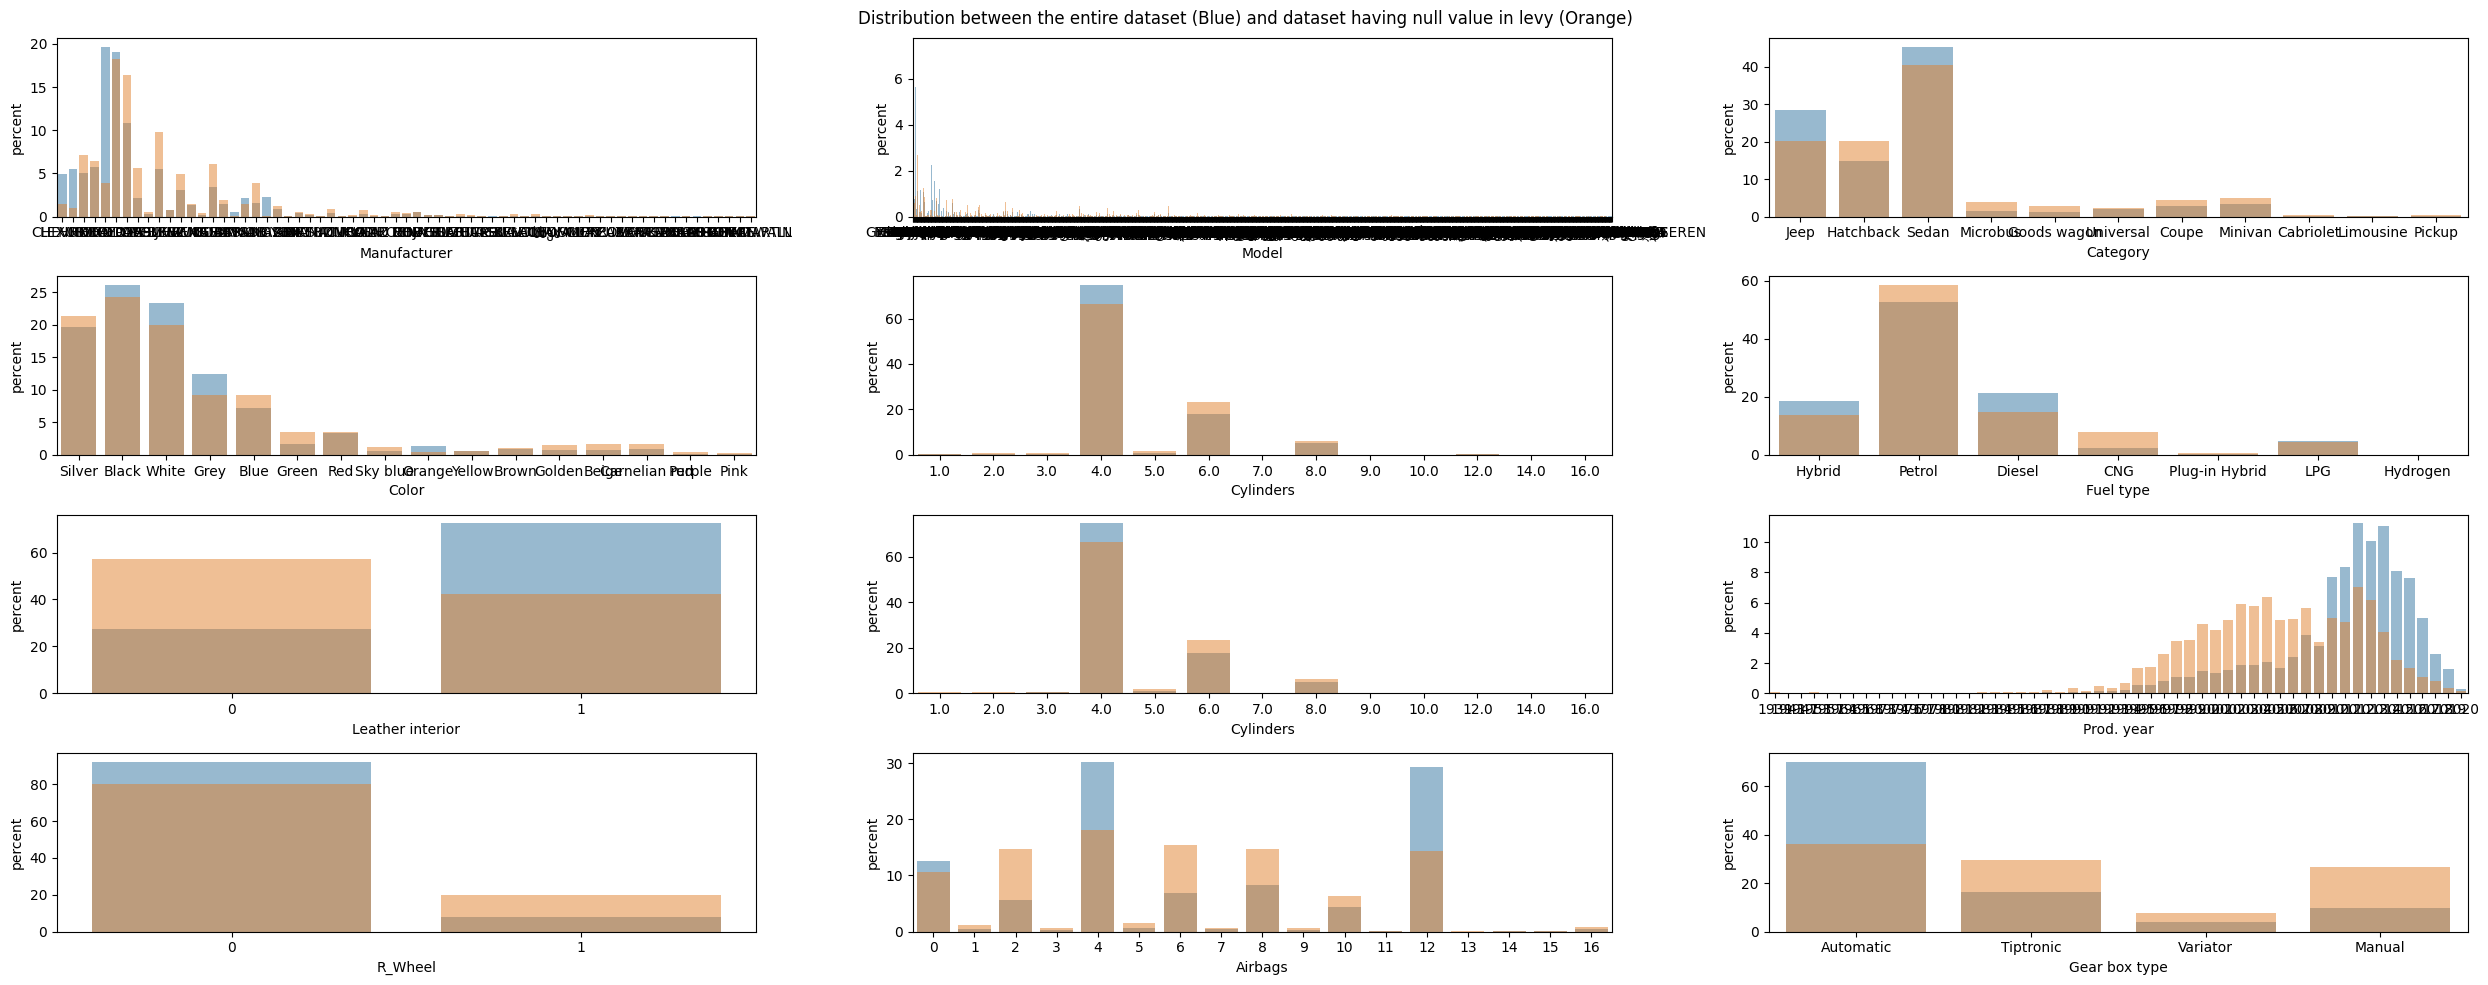

In [ ]:
cat_vars = ['Manufacturer','Model','Category','Color', 'Cylinders',  'Fuel type', 'Leather interior', 'Cylinders', 'Prod. year','R_Wheel', 'Airbags','Gear box type']
figs, axs = plt.subplots(4, 3, figsize=(25, 10))
for i in range(4):
  for j in range(3):
    sns.countplot(x=cat_vars[i*3+j], data=df, ax=axs[i, j], alpha=0.5, stat="percent")
    sns.countplot(x=cat_vars[i*3+j], data=df_null_levy, ax=axs[i, j], alpha=0.5, stat="percent")
plt.suptitle('Distribution between the entire dataset (Blue) and dataset having null value in levy (Orange)')
plt.tight_layout()
plt.show()

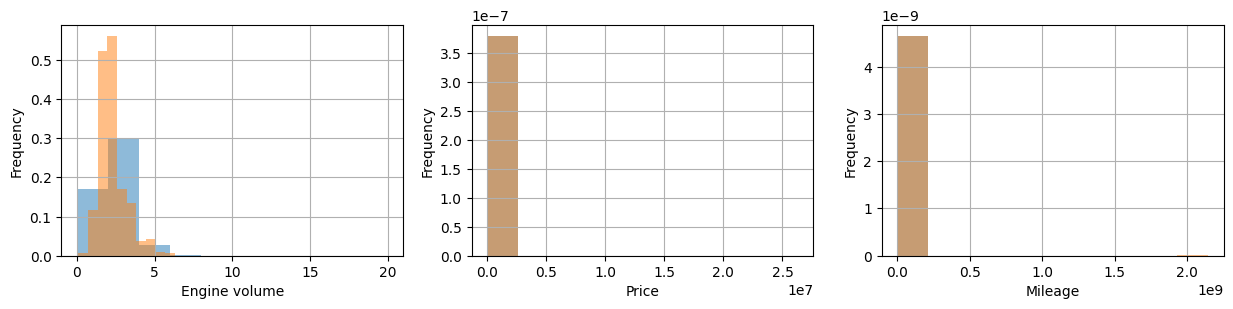

In [ ]:
num_vars = [ 'Engine volume', 'Price','Mileage']
figs, axs = plt.subplots(1, 3, figsize=(15, 3))
for i in range(1):
  for j in range(3):
    df[num_vars[j]].hist(ax=axs[j], alpha=0.5,density=True)
    df_null_levy[num_vars[j]].hist(ax=axs[j], alpha=0.5,density=True)
    axs[j].set_xlabel(num_vars[j])
    axs[j].set_ylabel('Frequency')

In [ ]:
len(df_null_levy)

5709

In [ ]:
len(df_null_levy) /  len(df)

0.30168040583386174

In [ ]:
df_null_levy.describe()

,ID,Price,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Airbags,engine_turbo,R_Wheel
count,5.709000e+03,5.709000e+03,5709.000000,5709.000000,5709.000000,5.709000e+03,5709.000000,5709.000000,5709.000000,5709.000000
mean,4.536207e+07,2.150699e+04,2005.777019,0.425118,2.284989,4.284874e+06,4.733929,5.860746,0.199159,0.200561
std,1.526814e+06,3.485743e+05,6.857943,0.494404,0.887822,8.307861e+07,1.349222,3.879950,0.399403,0.400455
min,2.074688e+07,1.000000e+00,1939.000000,0.000000,0.100000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,4.562111e+07,7.213000e+03,2002.000000,0.000000,1.600000,8.300000e+04,4.000000,2.000000,0.000000,0.000000
50%,4.577659e+07,1.200000e+04,2006.000000,0.000000,2.000000,1.490000e+05,4.000000,6.000000,0.000000,0.000000
75%,4.579411e+07,1.980000e+04,2011.000000,1.000000,2.600000,2.030000e+05,6.000000,8.000000,0.000000,0.000000
max,4.581665e+07,2.630750e+07,2020.000000,1.000000,6.300000,2.147484e+09,16.000000,16.000000,1.000000,1.000000


### Imputing with median

In [ ]:
df['Levy'] = df['Levy'].replace('-', (df[df['Levy'] != '-']['Levy']).astype(float).median())

In [ ]:
df['Levy'] = df['Levy'].astype(float)

The data with levy as null values has closely distribution to the entire dataset. 'mean' and'medien' are candidates for replacing this null. I decide to replace null values with **Median** because it is less sensitive to outliers.




## Summary

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              18924 non-null  float64
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  int64  
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  float64
 10  Mileage           18924 non-null  int64  
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  object 
 13  Drive wheels      18924 non-null  object 
 14  Color             18924 non-null  object 
 15  Airbags           18924 non-null  int64  
 16  engine_turbo      18924 non-null  int64  
 17

In [ ]:
df.describe()

,ID,Price,Levy,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Airbags,engine_turbo,R_Wheel
count,1.892400e+04,1.892400e+04,18924.000000,18924.000000,18924.000000,18924.000000,1.892400e+04,18924.000000,18924.000000,18924.000000,18924.000000
mean,4.557538e+07,1.858744e+04,868.498890,2010.914236,0.725587,2.306251,1.555373e+06,4.580216,6.568379,0.099979,0.076781
std,9.375468e+05,1.921356e+05,391.400489,5.665749,0.446230,0.877591,4.880221e+07,1.200223,4.322323,0.299980,0.266250
min,2.074688e+07,1.000000e+00,87.000000,1939.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,4.569501e+07,5.331000e+03,730.000000,2009.000000,0.000000,1.800000,7.019575e+04,4.000000,4.000000,0.000000,0.000000
50%,4.577191e+07,1.317200e+04,781.000000,2012.000000,1.000000,2.000000,1.264000e+05,4.000000,6.000000,0.000000,0.000000
75%,4.580174e+07,2.206300e+04,917.000000,2015.000000,1.000000,2.500000,1.891198e+05,4.000000,12.000000,0.000000,0.000000
max,4.581665e+07,2.630750e+07,11714.000000,2020.000000,1.000000,20.000000,2.147484e+09,16.000000,16.000000,1.000000,1.000000


# EDA

I have explored, visualized and looked deep into the dataset. I have got some insight by following:
* **Levy**: Most of variables has the value of **Levy between 0 to $2000.**
* **Engine** volume: Most of variables has **Engine volume between 0 to 5 L**.
* **Cylinders**: Most of variables has **4, 6, 8 of cylinders** respectively.
* **Airbages**: **4, 12 of airbags** are the most frequent respectively.
* **Most cars**, around 93%, has between **1000 km and 1 million km of mileage**.
* **Manufacturer**: Most of Manufacturer of cares are **Hyundai, Toyota and Mercedez-Benz** respectively
* **Category**: **Sedan, Jeep, and Hatchback** are the top 3 of the most frequent in category.
* **Prod. year**: Cars **produced in 2012** are the most frequent.
* **Color**: Most of cars are **Black, white, silver, grey** (, blue).
* **Fuel type**: Most of cars use **petrol** as fuel.
* **Gear box type**: Most of cars use **automatic gear**.
* **Drive wheel**: **Front drive** wheel is the most frequent.


And I also found that:
* TOYOTA has the lowest average price of the popular cars.
* And HYUNDAI has the highest average price and the most popular.
* LAMBORGHINI has the highest price in the dataset.

## Price: Target feature

Text(0.5, 1.0, 'Dist. of log(Price)')

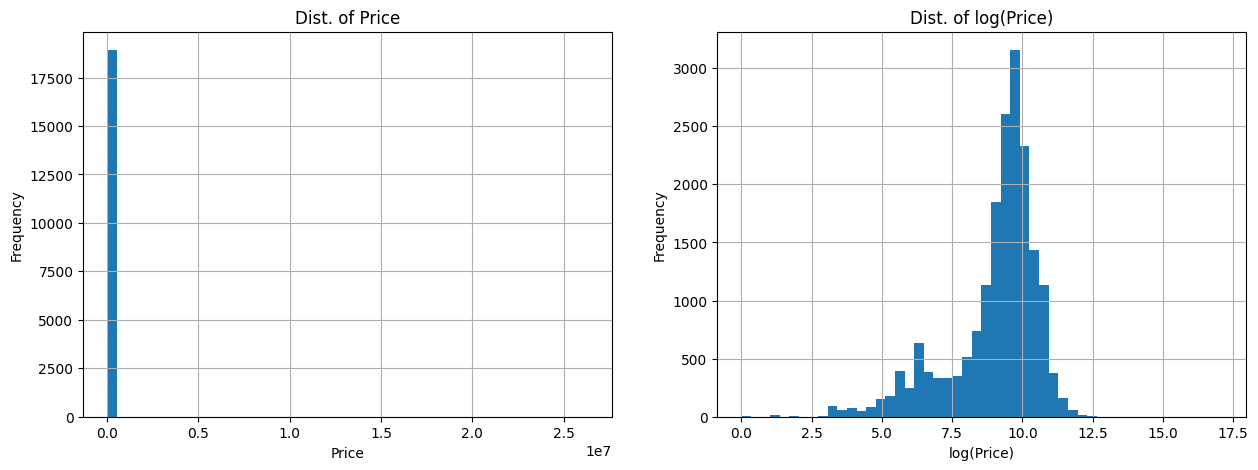

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df['Price'].hist(bins=50, ax=axes[0])
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Price')
axes[0].set_title('Dist. of Price')

np.log(df['Price']).hist(bins=50, ax=axes[1])
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('log(Price)')
axes[1].set_title('Dist. of log(Price)')

## Numeric Features

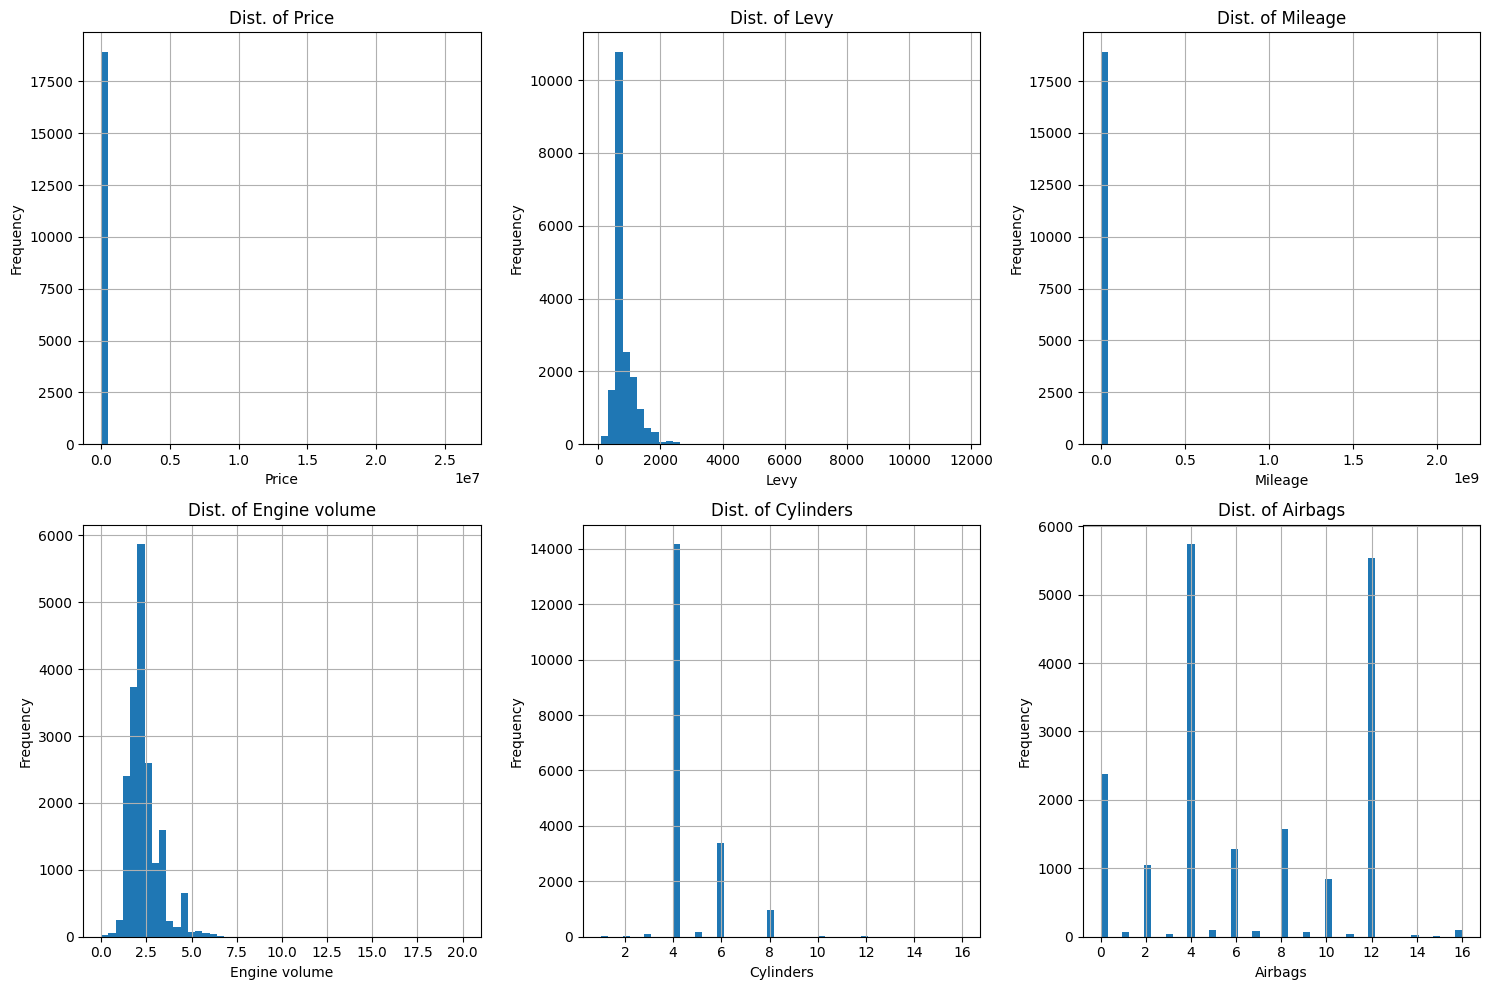

In [ ]:
num_vars = ['Price','Levy','Mileage', 'Engine volume', 'Cylinders','Airbags']
figs, axes = plt.subplots(2, 3, figsize=(15, 10))
for i,j in enumerate(num_vars):
  df[j].hist(bins=50, ax=axes[i//3, i%3]) #Plots the histogram on the correct axes object.
  axes[i//3, i%3].set_ylabel('Frequency') #Uses the axes object to set the ylabel
  axes[i//3, i%3].set_xlabel(j) #Uses the axes object to set the xlabel. Also changed i to j so that the label is the name of the column
  axes[i//3, i%3].set_title(f'Dist. of {j}')
plt.tight_layout()
plt.show()

* Levy: Most of variables has Levy between  0 to $2000.
* Engine volume: Most of variables has Engine volume between  0 to 5 L.
* Cylinders: Most of variables has 4, 6, 8 of cylinders respectively.
* Airbages: 4, 12 of airbags are the most frequent respectively.

<Figure size 1000x500 with 0 Axes>

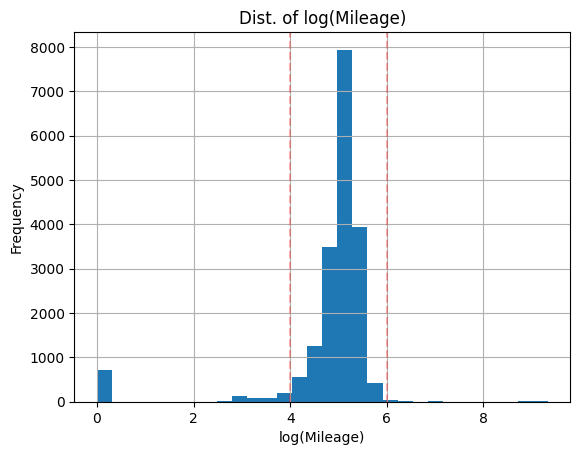

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots()
(np.log10(df['Mileage']+1)).hist(bins=30)
plt.ylabel('Frequency')
plt.xlabel('log(Mileage)')
plt.title('Dist. of log(Mileage)')

plt.axvline(x=4, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=6, color='r', linestyle='--', alpha=0.3)

plt.show()

In [ ]:
np.sum((df['Mileage'] >= 10000) & (df['Mileage'] <= 10**6)) / len(df)

0.934421898118791

Most cars, around 93%, has between 1000 km and 1 million km of mileage.

## Category Features

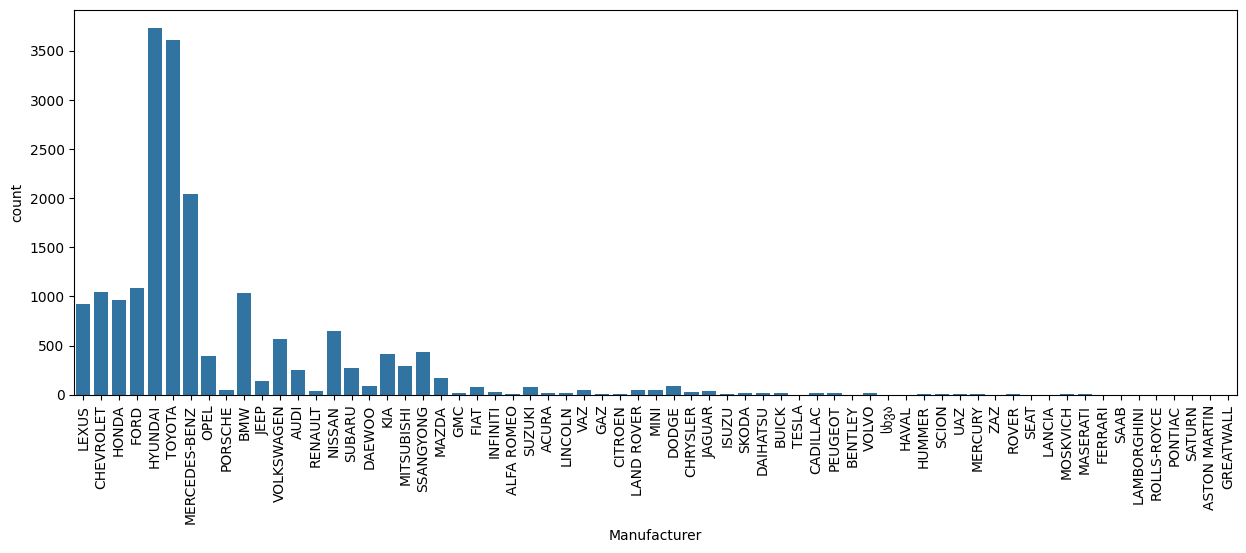

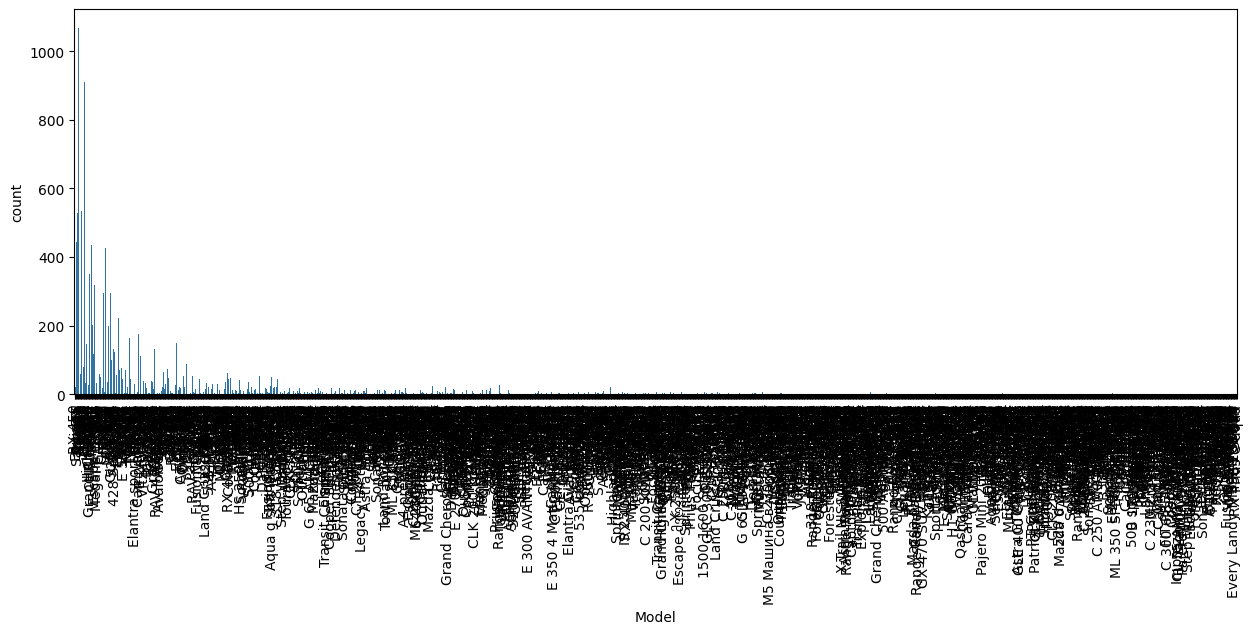

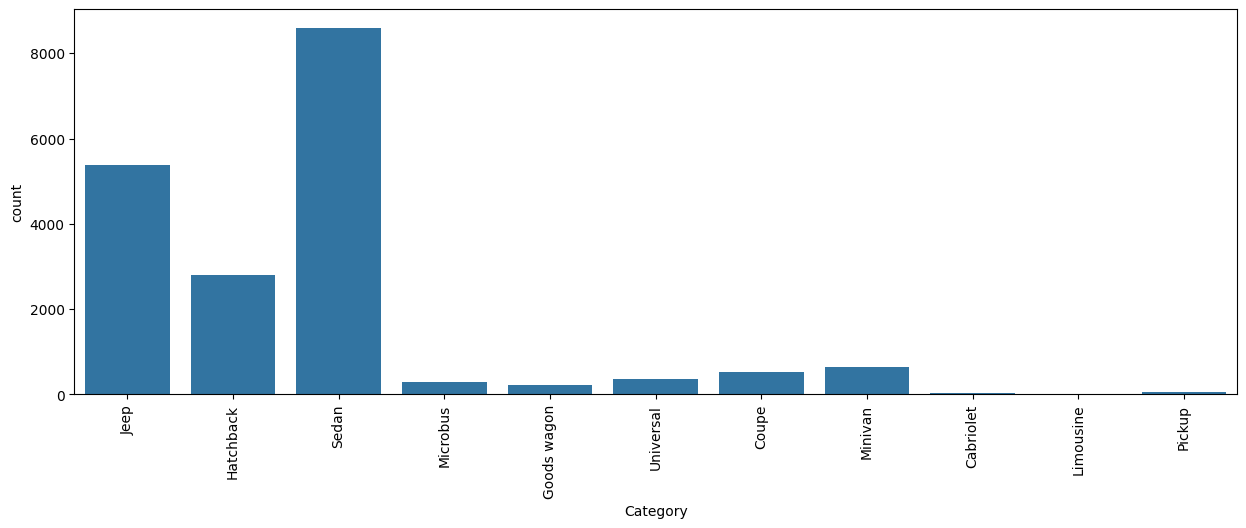

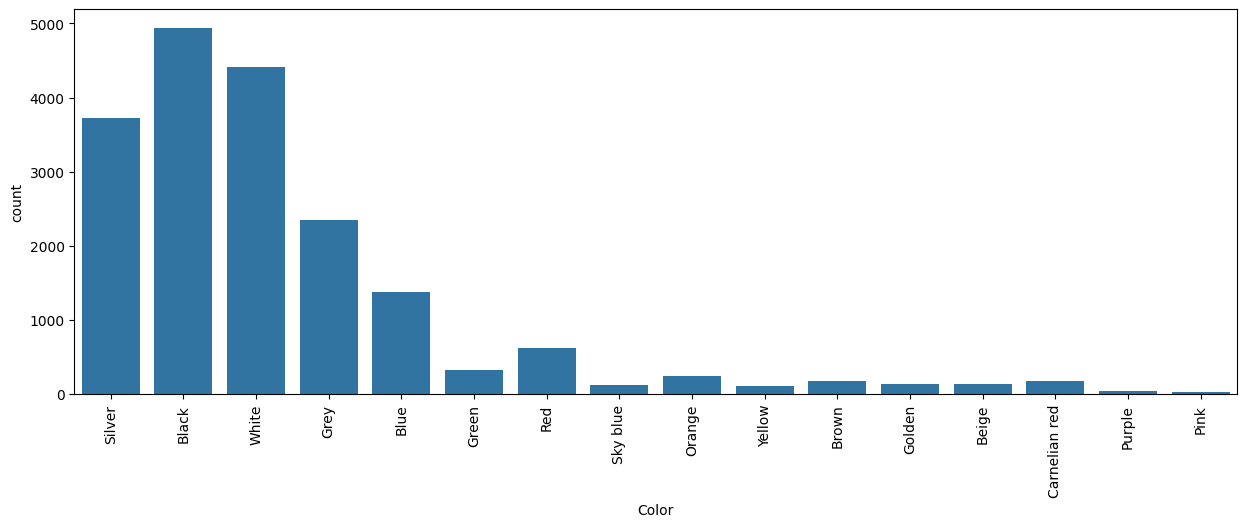

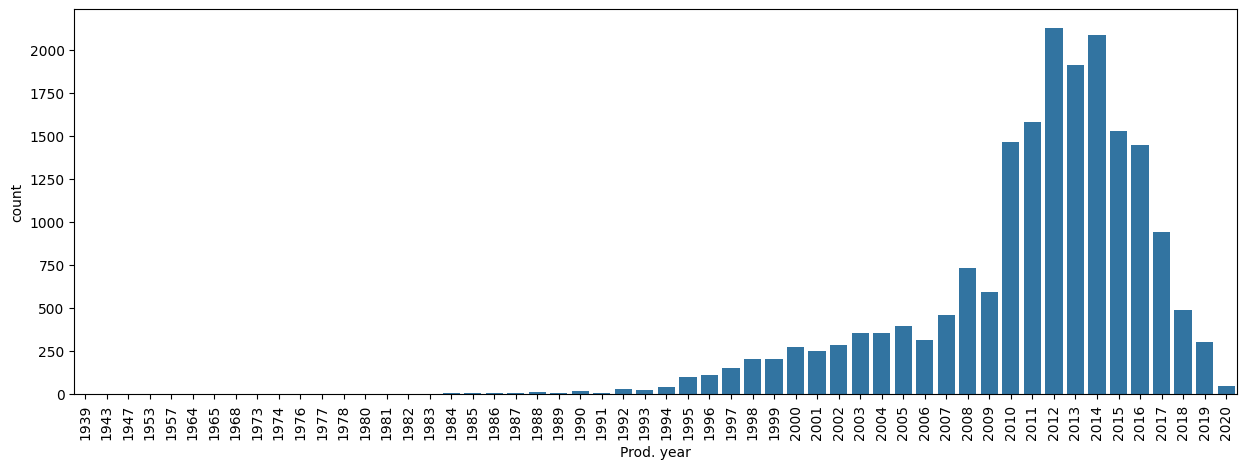

In [ ]:
cat_vars = ['Manufacturer','Model','Category','Color', 'Prod. year']
for i in cat_vars:
  plt.figure(figsize=(15,5))
  sns.countplot(x=i, data=df)
  plt.xticks(rotation=90)
  plt.show()

* Manufacturer: Most of Manufacturer of cares are Hyundai, Toyota and Mercedez-Benz respectively
* Category: Sedan, Jeep, and Hatchback are the top 3 of the most frequent in category.
* Prod. year: Cars produced in 2012 are the most frequent.
* Color: Most of cars are Black, white, silver, grey (, blue).

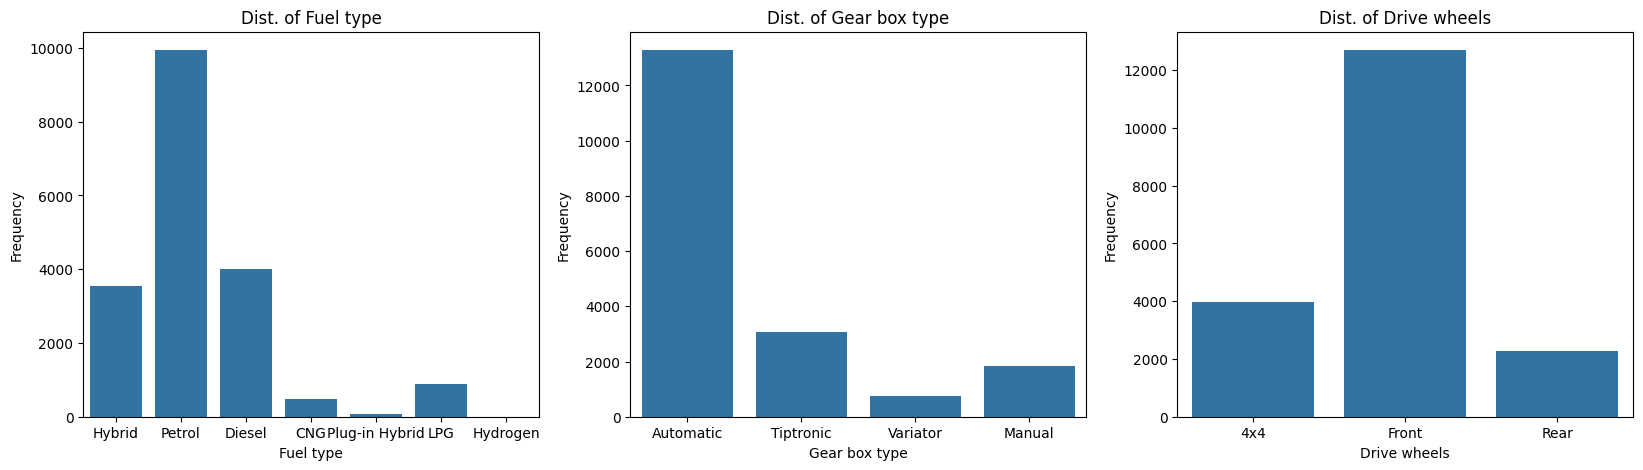

In [ ]:
cat_vars = ['Fuel type','Gear box type','Drive wheels']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i,j in enumerate(cat_vars):
  sns.countplot(x=j, data=df, ax=axes[i])
  axes[i].set_ylabel('Frequency')
  axes[i].set_xlabel(j)
  axes[i].tick_params(axis='x', rotation=0)
  axes[i].set_title(f'Dist. of {j}')

* Fuel type: Most of cars use petrol as fuel.
* Gear box type: Most of cars use automatic gear.
* Drive wheel: Front drive wheel is the most frequent.

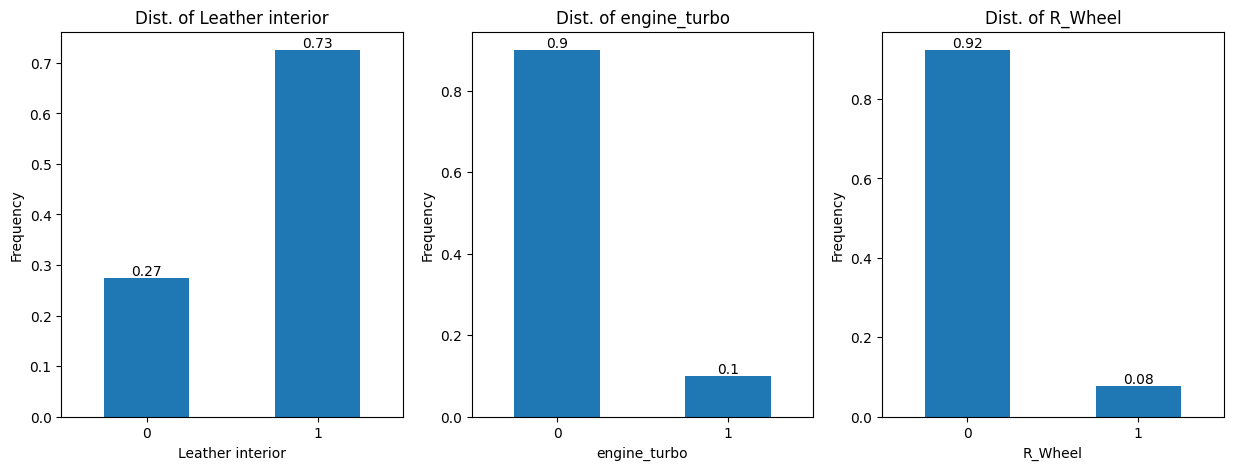

In [ ]:
bi_vars = ['Leather interior', 'engine_turbo','R_Wheel']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,j in enumerate(bi_vars):
  df[j].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[i])
  axes[i].set_ylabel('Frequency')
  axes[i].set_xlabel(j)
  axes[i].tick_params(axis='x', rotation=0)
  axes[i].set_title(f'Dist. of {j}')

  x_val = df[j].value_counts(normalize=True).sort_index().index
  y_val = df[j].value_counts(normalize=True).sort_index().values
  for x_val, y_val in zip(x_val, y_val):
    axes[i].annotate(str(round(y_val,2)), xy=(x_val, y_val), ha='center', va='bottom')

plt.show()

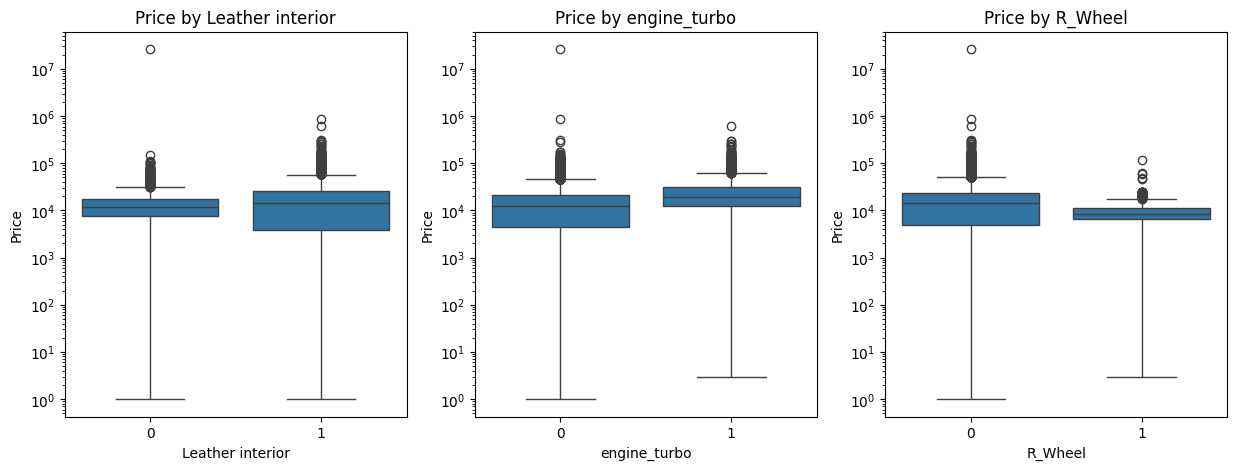

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,j in enumerate(['Leather interior', 'engine_turbo','R_Wheel']):
  sns.boxplot(x=j, y='Price', data=df, ax=axes[i])
  axes[i].set_ylabel('Price')
  axes[i].set_yscale('log')
  axes[i].set_xlabel(j)
  axes[i].tick_params(axis='x', rotation=0)
  axes[i].set_title(f'Price by {j}')

plt.show()

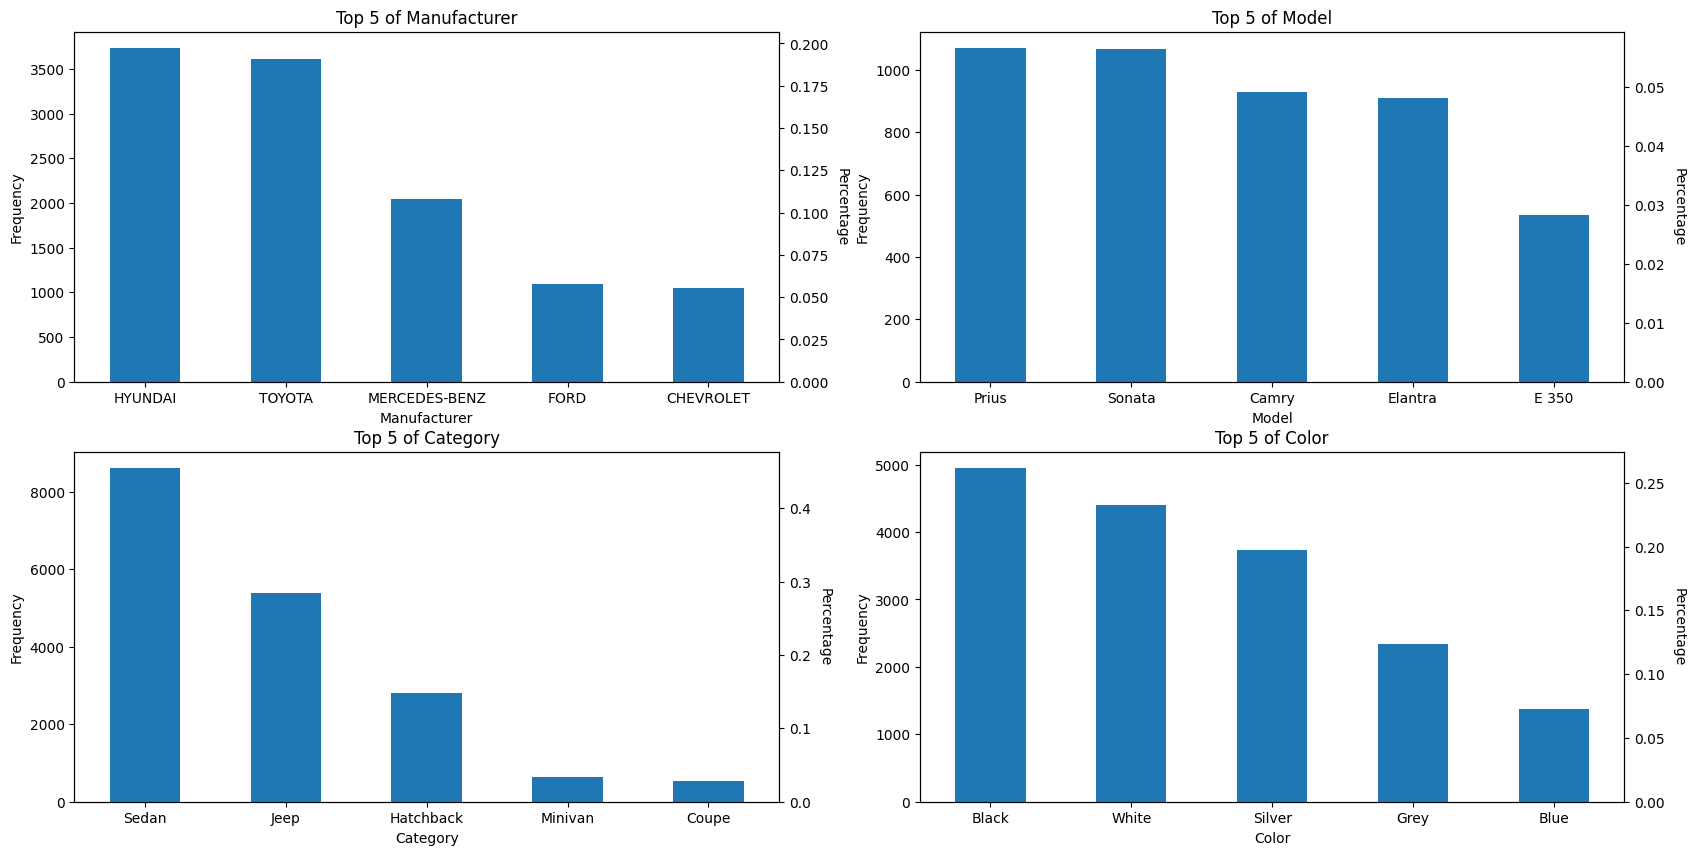

In [ ]:
cat_vars = ['Manufacturer','Model','Category','Color']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i,j in enumerate(cat_vars):
  df[j].value_counts().iloc[:5,].plot(kind='bar', ax=axes[i//2, i%2])
  axes[i//2, i%2].set_ylabel('Frequency')
  axes[i//2, i%2].set_xlabel(j)
  axes[i//2, i%2].tick_params(axis='x', rotation=0)
  axes[i//2, i%2].set_title(f'Top 5 of {j}')

  ax2 = axes[i//2, i%2].twinx()
  df[j].value_counts(normalize=True).iloc[:5,].plot(kind='bar', ax=ax2)
  ax2.set_ylabel('Percentage', rotation=270, labelpad=15)


plt.show()


In [ ]:
df.groupby('Manufacturer')['Price'].mean().loc[df['Manufacturer'].value_counts().head(5).index].round(0).rename('AVG Price')

,AVG Price
Manufacturer,
HYUNDAI,22306.0
TOYOTA,14302.0
MERCEDES-BENZ,18590.0
FORD,15412.0
CHEVROLET,14895.0


* TOYOTA has the lowest average price in the top 5 popular cars.
* And HYUNDAI has the highest average price and the most popular.

In [ ]:
df.groupby('Manufacturer')['Price'].mean().sort_values(ascending=False).head(5).rename('AVG Price')

,AVG Price
Manufacturer,
LAMBORGHINI,872946.000000
BENTLEY,197574.500000
OPEL,73474.893939
FERRARI,66955.500000
LAND ROVER,54807.187500


* LAMBORGHINI has the highest price in the dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              18924 non-null  float64
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  int64  
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  float64
 10  Mileage           18924 non-null  int64  
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  object 
 13  Drive wheels      18924 non-null  object 
 14  Color             18924 non-null  object 
 15  Airbags           18924 non-null  int64  
 16  engine_turbo      18924 non-null  int64  
 17

# Modelling

## Remove outliers

In [ ]:
cleaned_data = df.copy()

In [ ]:
def remove_nummeric_outlier(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
  return df

In [ ]:
# Remove rows with rare categories
def remove_category_outlier(df, col):
  df = df[df[col].map(df[col].value_counts()) > 30]
  return df

In [ ]:
for col in ['Price','Mileage']:
  cleaned_data = remove_nummeric_outlier(cleaned_data, col)

In [ ]:
for col in ['Manufacturer','Model','Category','Color', 'Prod. year', 'Cylinders']:
  cleaned_data = remove_category_outlier(cleaned_data, col)

In [ ]:
del cleaned_data['ID']

## LabelEncoding

In [ ]:
for cat in ['Manufacturer','Model','Category','Color','Fuel type','Gear box type','Drive wheels']:
  labelencoder = LabelEncoder()
  cleaned_data[cat] = labelencoder.fit_transform(cleaned_data[cat])

In [ ]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12895 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             12895 non-null  int64  
 1   Levy              12895 non-null  float64
 2   Manufacturer      12895 non-null  int64  
 3   Model             12895 non-null  int64  
 4   Prod. year        12895 non-null  int64  
 5   Category          12895 non-null  int64  
 6   Leather interior  12895 non-null  int64  
 7   Fuel type         12895 non-null  int64  
 8   Engine volume     12895 non-null  float64
 9   Mileage           12895 non-null  int64  
 10  Cylinders         12895 non-null  float64
 11  Gear box type     12895 non-null  int64  
 12  Drive wheels      12895 non-null  int64  
 13  Color             12895 non-null  int64  
 14  Airbags           12895 non-null  int64  
 15  engine_turbo      12895 non-null  int64  
 16  R_Wheel           12895 non-null  int64  
dty

In [ ]:
cleaned_data.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Color,Airbags,engine_turbo,R_Wheel
0,13328,1399.0,10,69,2010,3,1,2,3.5,186005,6.0,0,0,10,12,0,0
2,8467,781.0,6,33,2006,2,0,4,1.3,200000,4.0,3,1,1,2,0,1
3,3607,862.0,5,32,2011,3,1,2,2.5,168966,4.0,0,0,12,0,0,0
4,11726,446.0,6,33,2014,2,1,4,1.3,91901,4.0,0,1,10,4,0,0
5,39493,891.0,7,70,2016,3,1,1,2.0,160931,4.0,0,1,12,4,0,0


## Train-Test Split

In [ ]:
X = cleaned_data.drop('Price',axis=1).values
y = cleaned_data['Price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
def evaluate_model(model, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(model)
    print("Root Mean squared error:", rmse)
    print("R-squared score:", r2)
    return rmse, r2

In [ ]:
results = {'rmse':{}, 'r2':{}}

# Fitting

## Linear Regreassion

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [ ]:
rmse, r2 = evaluate_model(lm, y_test, lm.predict(X_test))
results['rmse']['Linear Regression'] = rmse
results['r2']['Linear Regression'] = r2

LinearRegression()
Root Mean squared error: 10296.950453207652
R-squared score: 0.2119942835901879


## Decision Tree Regression

In [ ]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
rmse, r2 = evaluate_model(clf, y_test, clf.predict(X_test))
results['rmse']['DecisionTree'] = rmse
results['r2']['DecisionTree'] = r2

DecisionTreeRegressor(random_state=42)
Root Mean squared error: 7242.423928265707
R-squared score: 0.6101657376183172


## RandomForest Regression

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
rmse, r2 = evaluate_model(rf, y_test, rf.predict(X_test))
results['rmse']['RandomForest'] = rmse
results['r2']['RandomForest'] = r2
#36s

RandomForestRegressor(random_state=42)
Root Mean squared error: 5179.742595630274
R-squared score: 0.8005984735889218


## Bagging Regression

In [ ]:
bg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, random_state=42)
bg.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100,
                 random_state=42)

In [ ]:
rmse, r2 = evaluate_model(bg, y_test, bg.predict(X_test))
results['rmse']['Bagging'] = rmse
results['r2']['Bagging'] = r2

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100,
                 random_state=42)
Root Mean squared error: 5186.624244911457
R-squared score: 0.8000682839569871


# Result

In [ ]:
pd.DataFrame(results)

,rmse,r2
Linear Regression,10296.950453,0.211994
DecisionTree,7242.423928,0.610166
RandomForest,5179.742596,0.800598
Bagging,5186.624245,0.800068


I chose **RandomForest Regressor** as a final model.

# Parameters Tuning

In [ ]:
params_grid = {
    'n_estimators': [50, 100, 125, 150],
    'max_depth': [None, 10, 15]
}
gs = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=params_grid,
    cv=5,
    n_jobs=-1,
    scoring=({
        'rmse': 'neg_mean_squared_error',
         'r2': 'r2'
         }),
    verbose=1,
    refit='rmse'

)

In [ ]:
gs.fit(X_train, y_train) # 2mins 30s

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 15],
                         'n_estimators': [50, 100, 125, 150]},
             refit='rmse',
             scoring={'r2': 'r2', 'rmse': 'neg_mean_squared_error'}, verbose=1)

In [ ]:
print('best_params_:', gs.best_params_)
print('best_score_:', (-gs.best_score_)**0.5)

best_params_: {'max_depth': None, 'n_estimators': 125}
best_score_: 5420.14299852661


In [ ]:
rmse, r2 = evaluate_model(gs, y_test, gs.predict(X_test))
results['rmse']['Bagging'] = rmse
results['r2']['Bagging'] = r2

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 15],
                         'n_estimators': [50, 100, 125, 150]},
             refit='rmse',
             scoring={'r2': 'r2', 'rmse': 'neg_mean_squared_error'}, verbose=1)
Root Mean squared error: 5190.69370193673
R-squared score: 0.7997544255893628


In [ ]:
gs.best_estimator_.feature_importances_

array([0.07907099, 0.03319391, 0.05417359, 0.21797128, 0.01971858,
       0.02202762, 0.09238495, 0.05792073, 0.1182715 , 0.01185347,
       0.06759314, 0.01440765, 0.03130066, 0.15703246, 0.01923122,
       0.00384824])

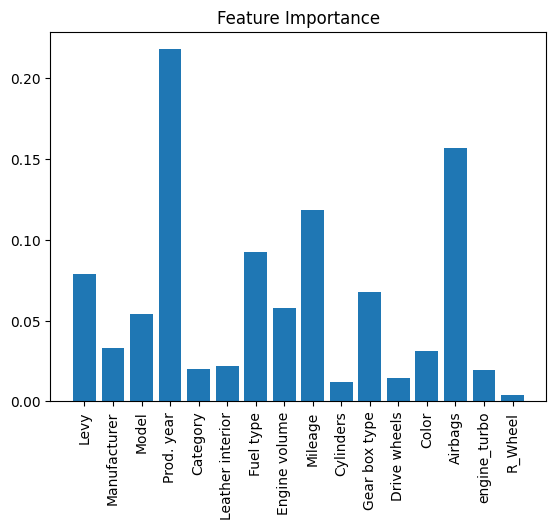

In [ ]:
best_model = gs.best_estimator_
feature_importances = best_model.feature_importances_
plt.bar(cleaned_data.drop('Price',axis=1).columns, feature_importances)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()



In [ ]:
y_pred = best_model.predict(X_test)
percent_error = (y_pred - y_test) / y_test
abs_percent_error = np.abs(percent_error)

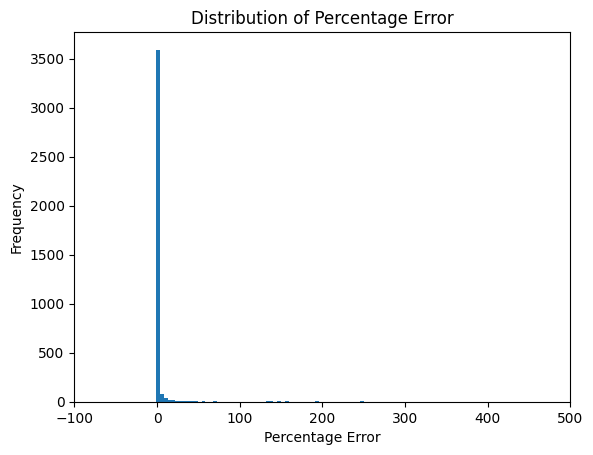

In [ ]:
plt.hist(percent_error, bins=2000)
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Error')
plt.xlim(-100, 500)
plt.show()

In [ ]:
print('Q1:',round(np.quantile(abs_percent_error,0.25), 2), '%')
print('Q3:',round(np.quantile(abs_percent_error,0.75), 2), '%')
print('95% CI', round(np.quantile(abs_percent_error,0.025), 3), 'to', round(np.quantile(abs_percent_error,0.975), 3), '%')

Q1: 0.05 %
Q3: 0.36 %
95% CI 0.0 to 34.107 %


In [ ]:
print('Median Error:', round(np.median(abs_percent_error),2),'%')
print('Average Error:', round(np.mean(abs_percent_error),2),'%')

Median Error: 0.14 %
Average Error: 9.82 %


In [ ]:
for i in np.arange(0,0.55,0.05):
  confident = round(sum(abs_percent_error < i) *100 / len(y_test),1)
  print(f'Percentage of predictions within +/- {round(i*100)}% range: {confident}% of the actual price.')

Percentage of predictions within +/- 0% range: 0.0% of the actual price.
Percentage of predictions within +/- 5% range: 26.5% of the actual price.
Percentage of predictions within +/- 10% range: 40.7% of the actual price.
Percentage of predictions within +/- 15% range: 51.8% of the actual price.
Percentage of predictions within +/- 20% range: 60.2% of the actual price.
Percentage of predictions within +/- 25% range: 65.9% of the actual price.
Percentage of predictions within +/- 30% range: 70.6% of the actual price.
Percentage of predictions within +/- 35% range: 74.1% of the actual price.
Percentage of predictions within +/- 40% range: 76.8% of the actual price.
Percentage of predictions within +/- 45% range: 78.7% of the actual price.
Percentage of predictions within +/- 50% range: 80.2% of the actual price.


In [ ]:
error = np.arange(0,10,0.05)
in_range  = []
for i in error:
  in_range.append(round(sum(abs_percent_error < i) *100 / len(y_test),1))

In [ ]:
confi_df = pd.DataFrame({'+/- percent error':error*100, 'in_range(%)':in_range})

,+/- percent error,in_range(%)
0,0.0,0.0
1,5.0,26.5
2,10.0,40.7
3,15.0,51.8
4,20.0,60.2


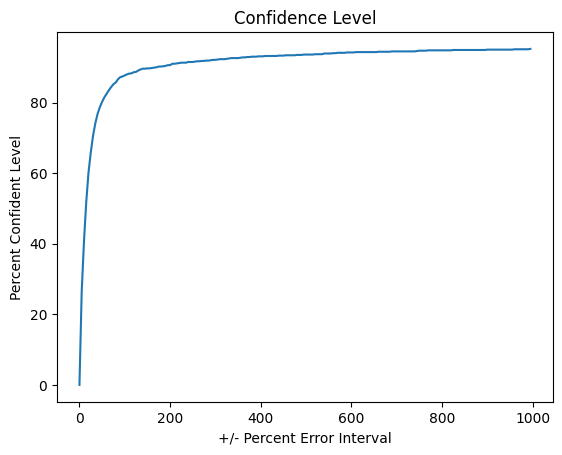

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
sns.lineplot(x='+/- percent error', y='in_range(%)', data=confi_df)
plt.title('Confidence Level')
plt.xlabel('+/- Percent Error Interval')
plt.ylabel('Percent Confident Level')
plt.show()
plt